### 1.Importing Required Libraries for NLP & ML Project

In [1]:
# ============================================================
# 📦 Importing Required Libraries for NLP & ML Project
# ============================================================

# ===============================
# Basic Libraries
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

# ===============================
# Utilities & Helpers
# ===============================
import re
import string
import random
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# ===============================
# Data Balancing & Processing
# ===============================
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

# ===============================
# NLP (Natural Language Processing)
# ===============================
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# ===============================
# Feature Extraction
# ===============================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ===============================
# Model Training & Selection
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize

# ===============================
# Machine Learning Models
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# ===============================
# Evaluation Metrics & Visualization
# ===============================
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)

# ===============================
# Data Handling
# ===============================
from sklearn.utils import shuffle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMLS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\PMLS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#load the data
df = pd.read_csv('Combined Data.csv', index_col=0)

In [3]:
#Drop NULLs
df.dropna(inplace = True)

In [4]:
df.shape

(52681, 2)

In [5]:
# df = df.iloc[:,1:]

In [6]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.describe().T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


In [8]:
#As we are going to do multi-class classifications here, simple label encode the df
import joblib
label_encoder = joblib.load('Models/le.pkl') #LabelEncoder()
df['encoded_status'] = label_encoder.fit_transform(df['status'])

In [9]:
df.head()

,statement,status,encoded_status
0,oh my gosh,Anxiety,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0
3,I've shifted my focus to something else but I'...,Anxiety,0
4,"I'm restless and restless, it's been a month n...",Anxiety,0


After bacis cleaning dropping the NULLs, the data contains 52681 records with 2 columns, statement \(text\) and status \(status\) .
There are 7 unique status, we use a simple label encoding to represent this

## 1 Classical ML Model

## 1.0 Pre-processing for classical ML Models


In [10]:
#make a copy of data especially for classical ML Models
df1 = df.copy()

In [11]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    """Cleans input text from social media for NLP models.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df1['statement'] = df1['statement'].apply(clean_text)

In [12]:
#Step 2: stopwords removal
#Stop words (e.g., "and", "is", "the") do not carry much meaning and can be removed to reduce noise.
stop_words = set(stopwords.words('english'))
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [13]:
#Step 3：lemmatize
# Reduces words to their base or root forms, ensuring that variations of the same word are treated equally (e.g., "running", "runs", "ran" → "run").
lemmatizer = WordNetLemmatizer()
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [14]:
#Step 4: Train-Test Split
#Random sample, use 20% data for test, 80% data for train
X1 = df['statement']
y1 = df['encoded_status']
random.seed(1234)
# Initial train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X1.tolist(), y1.tolist(), test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train_1, y_train_1, test_size=0.25, random_state=42  # for validation: 0.25 * 0.8 = 0.2 of original data
)


In [15]:
# Step 5: TF-IDF Vectorization
#Converts raw text into numerical features for input to ML models
# joblib.load('tfidf_vectorizer_1.pkl')
tfidf = joblib.load('Models/tfidf_vectorizer_1.pkl') #TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_tfidf_1 = tfidf.transform(X_train_1)  # Fit on training data
X_test_tfidf_1 = tfidf.transform(X_test_1)       # Transform test data
#joblib.dump(tfidf,"tfidf_vectorizer_1.pkl")
# Initialize the TF-IDF Vectorizer
tfidf = joblib.load('Models/tfidf_vectorizer_2.pkl')#TfidfVectorizer(max_features=10000, stop_words='english')
#joblib.load('tfidf_vectorizer_2.pkl')

# Fit TF-IDF on training data
#tfidf.fit(X_train_1)
#joblib.dump(tfidf,"tfidf_vectorizer_2.pkl")
# Transform train, validation, and test sets
X_train_1= tfidf.transform(X_train_1)
X_val_1 = tfidf.transform(X_val_1)
X_test_1 = tfidf.transform(X_test_1)

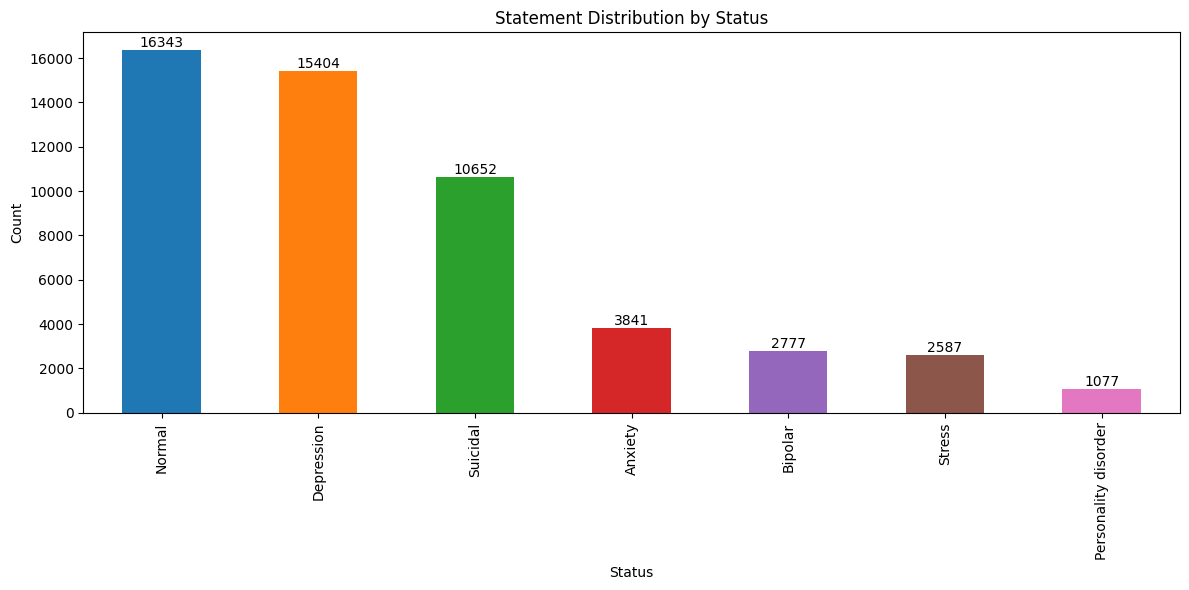

In [16]:
#Step 6: Handeling class-imbalance
# As shown by below plot, there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training set, we will do so by using a balanced class weights in training
# plt.figure(figsize=(12,8))
# status_counts = df1['status'].value_counts()
# ax = status_counts.plot(kind='bar')
# for i, v in enumerate(status_counts):
#     ax.text(i, v, str(v), ha='center', va='bottom')

# plt.title('Statement distribution by status')
# plt.xlabel('Status')
# plt.ylabel('Count')
# plt.tight_layout()
# plt.show()

import matplotlib.cm as cm

plt.figure(figsize=(12,6))
status_counts = df1['status'].value_counts()

# Use a color map to generate distinct colors
colors = cm.tab10(range(len(status_counts)))  # 'tab10', 'Set3', 'viridis', etc.

ax = status_counts.plot(kind='bar', color=colors)

for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement Distribution by Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## 1.0 SVM

In [17]:
random.seed(1234)

# Reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'kernel': ['linear', 'rbf'],  # Commonly used kernels
    'class_weight': ['balanced',None], # Handle class imbalance
    'gamma': ['scale'],           # Default kernel coefficient
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, kernel, class_weight, gamma in product(param_grid['C'], param_grid['kernel'], param_grid['class_weight'], param_grid['gamma']):
    try:
        # Create the SVM model with current parameters
        model = SVC(C=C, kernel=kernel, class_weight=class_weight, gamma=gamma, random_state=42)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'kernel': kernel, 'class_weight': class_weight, 'gamma': gamma}
    except Exception as e:
        print(f"Skipping combination C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, kernel=linear, class_weight=balanced, gamma=scale: 0.7188
Validation F1-Score for C=0.1, kernel=linear, class_weight=None, gamma=scale: 0.6884
Validation F1-Score for C=0.1, kernel=rbf, class_weight=balanced, gamma=scale: 0.6810
Validation F1-Score for C=0.1, kernel=rbf, class_weight=None, gamma=scale: 0.5584
Validation F1-Score for C=1, kernel=linear, class_weight=balanced, gamma=scale: 0.7542
Validation F1-Score for C=1, kernel=linear, class_weight=None, gamma=scale: 0.7549
Validation F1-Score for C=1, kernel=rbf, class_weight=balanced, gamma=scale: 0.7619
Validation F1-Score for C=1, kernel=rbf, class_weight=None, gamma=scale: 0.7576
Validation F1-Score for C=10, kernel=linear, class_weight=balanced, gamma=scale: 0.7339
Validation F1-Score for C=10, kernel=linear, class_weight=None, gamma=scale: 0.7257
Validation F1-Score for C=10, kernel=rbf, class_weight=balanced, gamma=scale: 0.7639
Validation F1-Score for C=10, kernel=rbf, class_weight=None, gamma=

In [18]:
SVM = SVC(C=10, kernel='rbf', class_weight='balanced', gamma='scale', random_state=42,probability=True)

# Train the model
SVM.fit(X_train_1, y_train_1)

SVC(C=10, class_weight='balanced', probability=True, random_state=42)

In [19]:
# Load model and encoder
SVM = joblib.load('Models/svm_model_multi.pkl')
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample
def bootstrap_auc_ci_multiclass(y_true, y_scores, n_classes, n_iterations=1000, average="macro"):
    auc_scores = []
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        y_true_sample = y_true_bin[indices]
        y_scores_sample = y_scores[indices]
        try:
            auc_sample = roc_auc_score(y_true_sample, y_scores_sample, average=average, multi_class="ovr")
            auc_scores.append(auc_sample)
        except ValueError:
            continue

    return np.mean(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)


def plot_multiclass_roc(y_true, y_score, n_classes, label_prefix="Model"):
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(["blue", "green", "red", "cyan", "magenta", "orange", "darkblue"])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label_prefix} - Multi-class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper

def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_multiclass(model, X_test, y_test, model_name="Model"):
    print(f"\n--- Evaluation Report: {model_name} ---\n")
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # F1 Score with CI
    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    # Confusion Matrix
    labels = list(np.unique(y_test))
    plot_confusion_matrix(y_test, y_pred, labels=labels)

    # ROC & AUC (One-vs-Rest)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print("Model doesn't support probability or decision scores.")
        return

    n_classes = len(np.unique(y_test))
    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci_multiclass(y_test, y_scores, n_classes)
    print(f"Macro-Averaged AUC: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_multiclass_roc(y_test, y_scores, n_classes, label_prefix=model_name)





--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8276    0.7947    0.8108       755
           1     0.9061    0.6774    0.7752       527
           2     0.6678    0.7444    0.7040      3016
           3     0.8576    0.9429    0.8982      3308
           4     0.9224    0.4515    0.6062       237
           5     0.7554    0.4608    0.5724       536
           6     0.6959    0.6372    0.6652      2158

    accuracy                         0.7640     10537
   macro avg     0.8047    0.6727    0.7189     10537
weighted avg     0.7667    0.7640    0.7593     10537

Weighted F1 Score: 0.7595
95% CI for F1 Score: [0.7516, 0.7679]


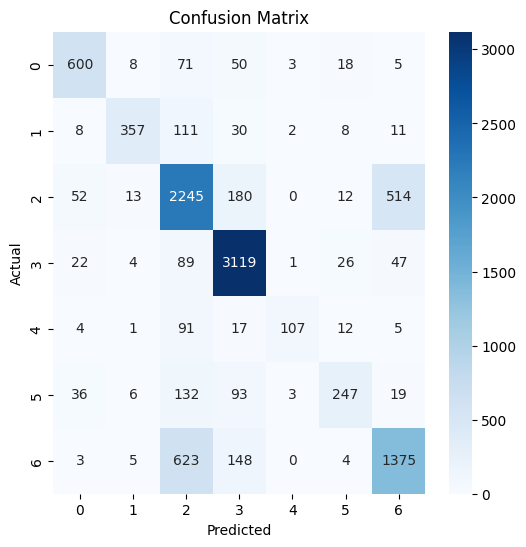

Macro-Averaged AUC: 0.9571
95% CI for AUC: [0.9543, 0.9598]


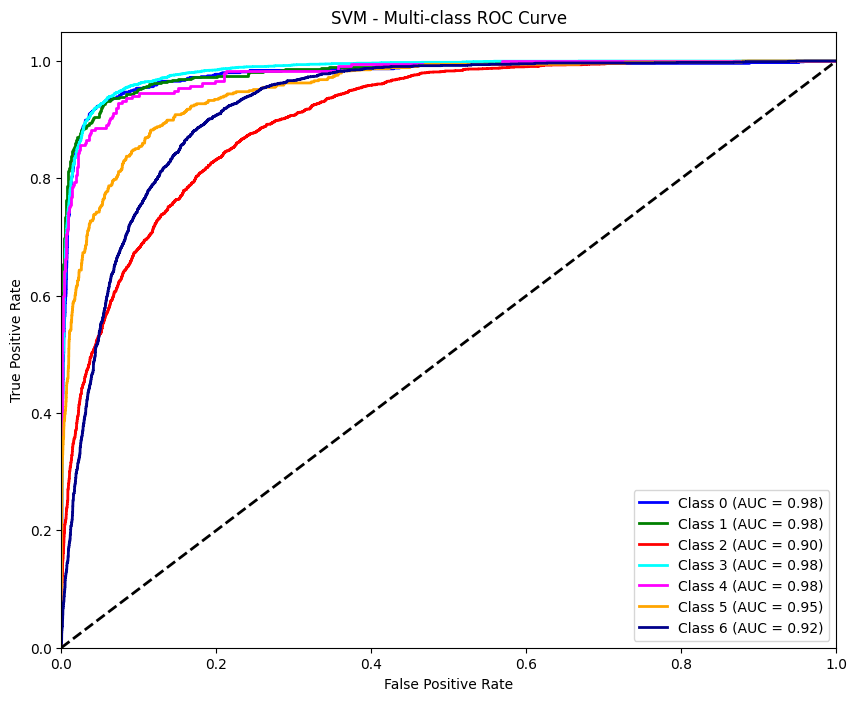

In [20]:
evaluate_model_multiclass(SVM, X_test_1, y_test_1, model_name="SVM")

## 1.1 Logistic Regression

In [21]:
random.seed(1234)

# Reduced parameter grid for logistic regression
param_grid = {
    'C': [0.1, 1, 10],                # Regularization strength
    'solver': ['lbfgs', 'saga'],      # Optimization solvers
    'penalty': ['l2'],                # L2 regularization
    'multi_class': ['multinomial'],   # Multiclass strategy: using multinomial for multi-class classification
    'class_weight': ['balanced', None],     # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, solver, penalty, multi_class, class_weight in product(
        param_grid['C'], param_grid['solver'], param_grid['penalty'], param_grid['multi_class'], param_grid['class_weight']):
    try:
        # Create the Logistic Regression model with current parameters
        model = LogisticRegression(
            C=C,
            solver=solver,
            penalty=penalty,
            multi_class=multi_class,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'C': C,
                'solver': solver,
                'penalty': penalty,
                'multi_class': multi_class,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7062
Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.6545
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7067
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.6544
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7503
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.7472
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7171
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.7475
Validation F1-Score for C=10, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7467
Validation F1-Score f

In [22]:

LR = LogisticRegression(
    C=10,
    solver='lbfgs',
    penalty='l2',
    multi_class='multinomial',
    class_weight=None,
    max_iter=1000,
    random_state=42
)

# Train the model
LR.fit(X_train_1, y_train_1)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial',
                   random_state=42)


--- Evaluation Report: Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8095    0.7709    0.7897       755
           1     0.8645    0.7021    0.7749       527
           2     0.6658    0.7029    0.6839      3016
           3     0.8651    0.9290    0.8959      3308
           4     0.8411    0.5359    0.6546       237
           5     0.6586    0.5075    0.5732       536
           6     0.6541    0.6335    0.6436      2158

    accuracy                         0.7508     10537
   macro avg     0.7655    0.6831    0.7165     10537
weighted avg     0.7498    0.7508    0.7480     10537

Weighted F1 Score: 0.7483
95% CI for F1 Score: [0.7404, 0.7572]


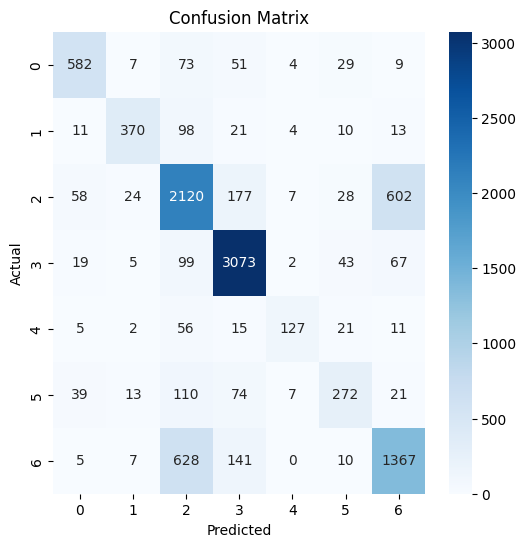

Macro-Averaged AUC: 0.9485
95% CI for AUC: [0.9453, 0.9514]


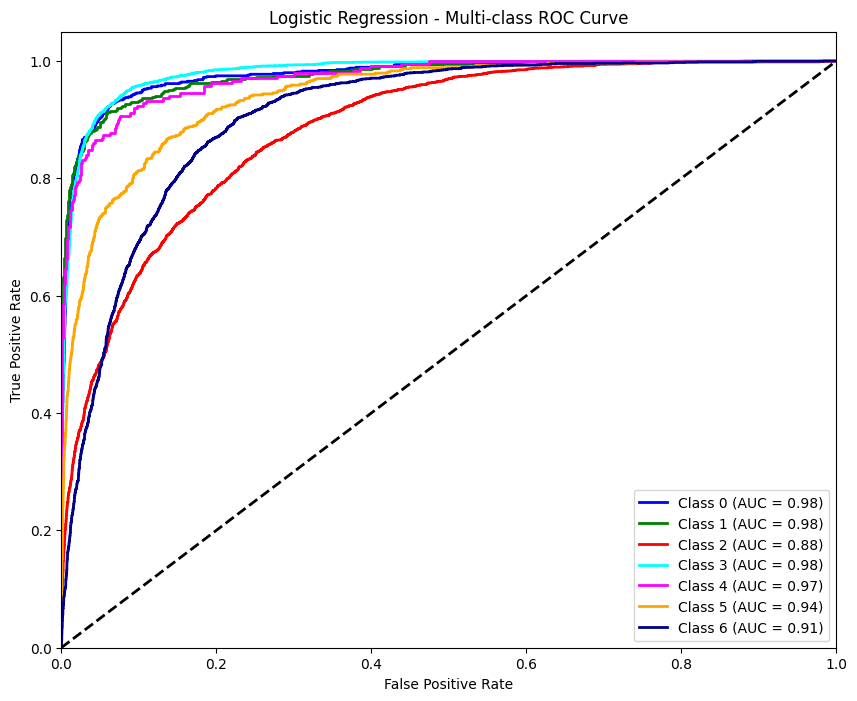

In [23]:
evaluate_model_multiclass(LR, X_test_1, y_test_1, model_name="Logistic Regression")

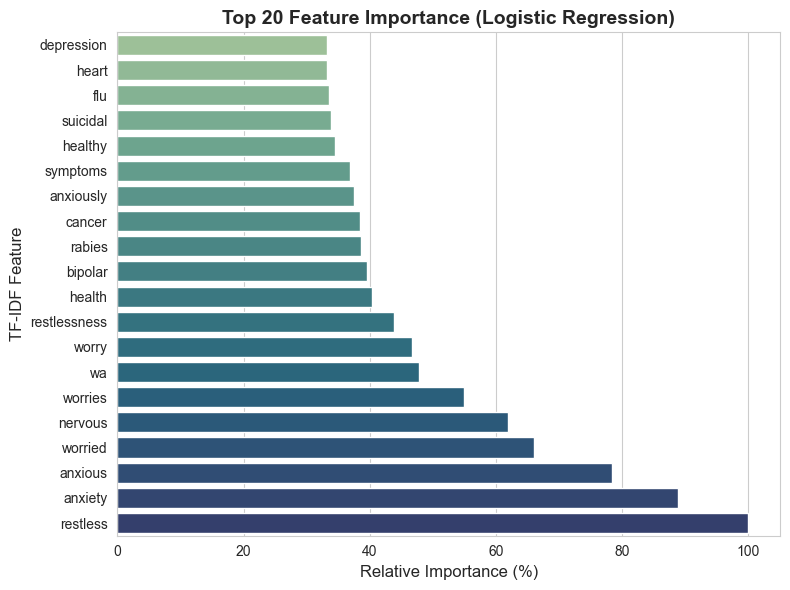

           Feature  Coefficient  Scaled Importance
7448      restless    13.035849         100.000000
628        anxiety    11.571409          88.766059
629        anxious    10.208034          78.307399
9880       worried     8.601834          65.985994
5916       nervous     8.073097          61.929967
9881       worries     7.153958          54.879108
9633            wa    -6.224914          47.752275
9883         worry     6.081539          46.652422
7449  restlessness     5.715338          43.843239
4208        health     5.263009          40.373351
1106       bipolar    -5.166312          39.631570
7038        rabies     5.037078          38.640200
1459        cancer     5.017342          38.488802
630      anxiously     4.885071          37.474130
8741      symptoms     4.805356          36.862626
4214       healthy     4.487416          34.423654
8620      suicidal    -4.412485          33.848853
3655           flu     4.376823          33.575281
4220         heart     4.325396

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract feature names
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from the trained Logistic Regression model
coefficients = LR.coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Use absolute value for importance
importance_df['Importance (Abs)'] = importance_df['Coefficient'].abs()

# Normalize importance (rescale to 0–100)
importance_df['Scaled Importance'] = (
    importance_df['Importance (Abs)'] / importance_df['Importance (Abs)'].max()
) * 100

# Sort and take top 20
top_20_features = importance_df.sort_values(by='Importance (Abs)', ascending=False).head(20)

# Plot (horizontal bar chart)
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    x='Scaled Importance',
    y='Feature',
    data=top_20_features[::-1],  # Reverse for descending top-down
    palette="crest"
)

plt.title("Top 20 Feature Importance (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (%)", fontsize=12)
plt.ylabel("TF-IDF Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save high-res for paper
plt.savefig("top_features_lr.png", dpi=300)
plt.show()

# Optionally print the top 20
print(top_20_features[['Feature', 'Coefficient', 'Scaled Importance']])


## 1.2 Random Forest

In [25]:
random.seed(1234)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20],          # Depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'class_weight': ['balanced', None],   # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight in product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_split'],
        param_grid['min_samples_leaf'],
        param_grid['class_weight']):
    try:
        # Create the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)



Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=balanced: 0.7045
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None: 0.6843
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=balanced: 0.7306
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=None: 0.6743
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=balanced: 0.7251
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=None: 0.6466
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=balanced: 0.7221
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=None:

In [26]:
# Create the Random Forest model with current parameters
RandomForest = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train the model
RandomForest.fit(X_train_1, y_train_1)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200, random_state=42)


--- Evaluation Report: RandomForest ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7140    0.8066    0.7575       755
           1     0.8036    0.7685    0.7856       527
           2     0.7027    0.6472    0.6738      3016
           3     0.8769    0.9129    0.8945      3308
           4     0.9015    0.5021    0.6450       237
           5     0.5929    0.4646    0.5209       536
           6     0.6347    0.7076    0.6691      2158

    accuracy                         0.7479     10537
   macro avg     0.7466    0.6871    0.7066     10537
weighted avg     0.7482    0.7479    0.7453     10537

Weighted F1 Score: 0.7453
95% CI for F1 Score: [0.7369, 0.7532]


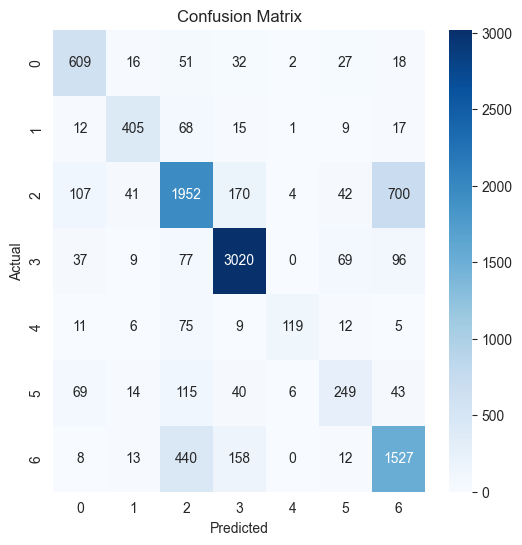

Macro-Averaged AUC: 0.9434
95% CI for AUC: [0.9402, 0.9466]


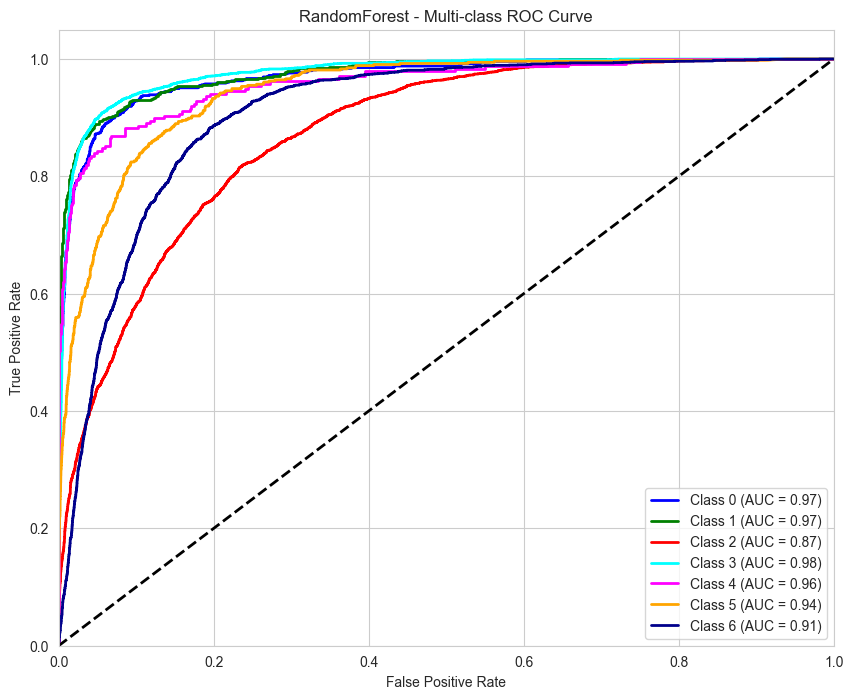

In [27]:
evaluate_model_multiclass(RandomForest, X_test_1, y_test_1, model_name="RandomForest")

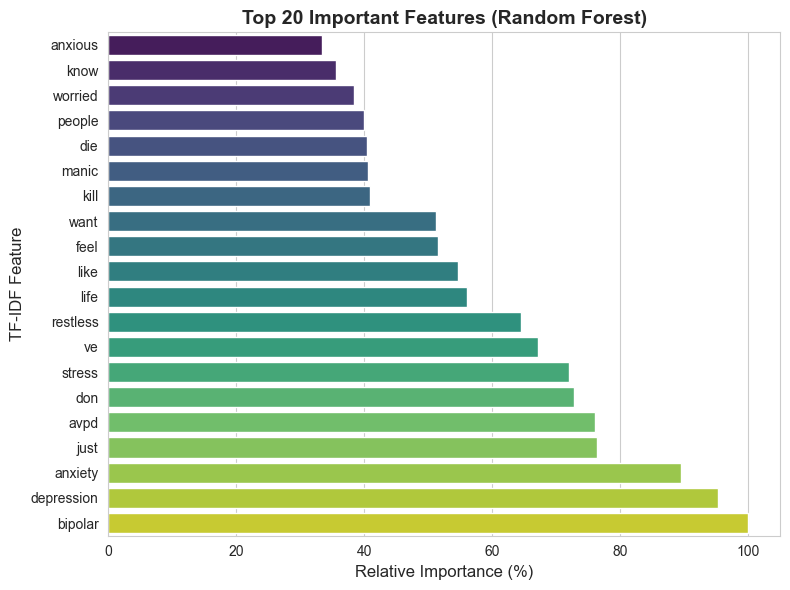

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if RandomForest is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = RandomForest.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (Random Forest)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_rf.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


## 1.3 LGBM

In [29]:
random.seed(1234)

# Parameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 200],          # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'num_leaves': [31, 63],              # Maximum number of leaves in a tree
    'max_depth': [None, 10],             # Maximum tree depth
    'class_weight': ['balanced', None],      # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, learning_rate, num_leaves, max_depth, class_weight in product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['class_weight']):
    try:
        # Create the LightGBM model with current parameters
        model = LGBMClassifier(
            objective='multiclass',                # Multi-class objective
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
            importance_type='gain'
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'num_leaves': num_leaves,
                'max_depth': max_depth,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.513405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248244
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 5192
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Validation F1-Score for n_estimators=100, learning_rate=0.01, num_leaves=31, max_depth=None, class_weight=balanced: 0.6852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.493195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248244
[LightGB

In [30]:
LGBM = LGBMClassifier(
    objective='multiclass',                # Multi-class objective
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=63,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    importance_type='gain'
)

# Train the model
LGBM.fit(X_train_1, y_train_1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248244
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 5192
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


LGBMClassifier(class_weight='balanced', importance_type='gain', max_depth=None,
               n_estimators=200, num_leaves=63, objective='multiclass',
               random_state=42)


--- Evaluation Report: LightGBM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.8358    0.8147       755
           1     0.8809    0.8140    0.8462       527
           2     0.7158    0.7016    0.7086      3016
           3     0.9078    0.9202    0.9140      3308
           4     0.8750    0.5612    0.6838       237
           5     0.6331    0.5989    0.6155       536
           6     0.6613    0.7011    0.6806      2158

    accuracy                         0.7770     10537
   macro avg     0.7812    0.7333    0.7519     10537
weighted avg     0.7782    0.7770    0.7765     10537

Weighted F1 Score: 0.7765
95% CI for F1 Score: [0.7689, 0.7846]


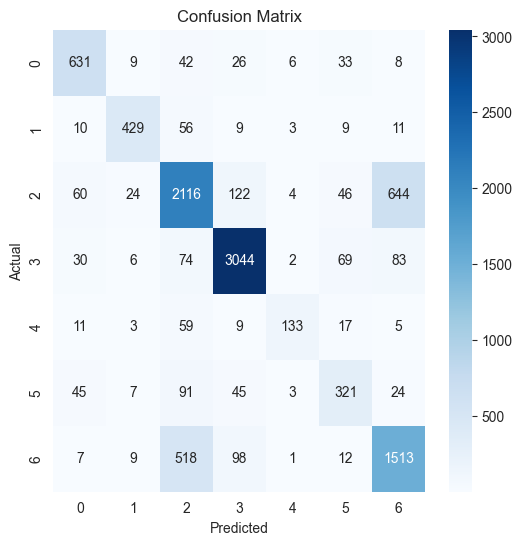

Macro-Averaged AUC: 0.9566
95% CI for AUC: [0.9537, 0.9597]


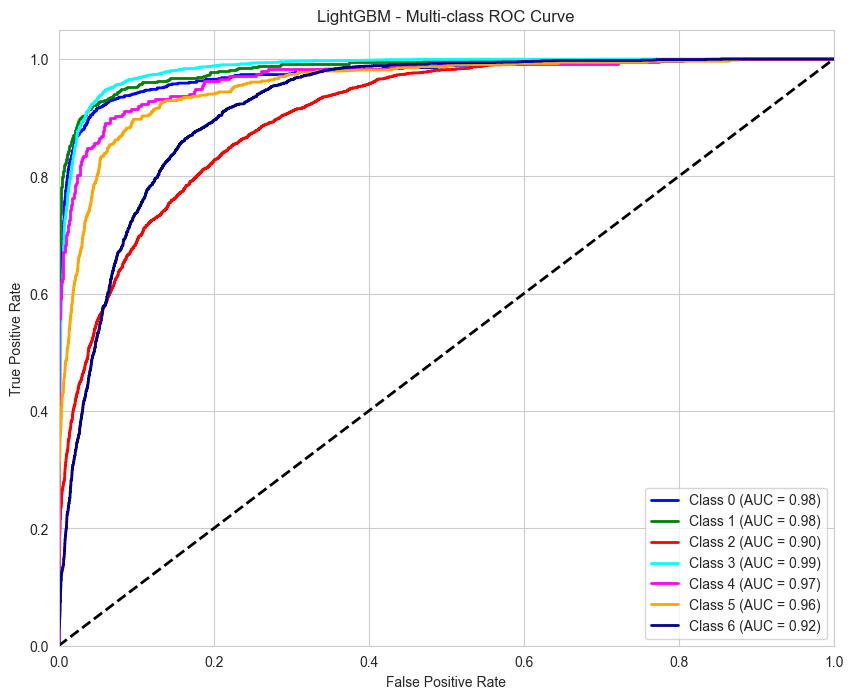

In [31]:
evaluate_model_multiclass(LGBM, X_test_1, y_test_1, model_name="LightGBM")

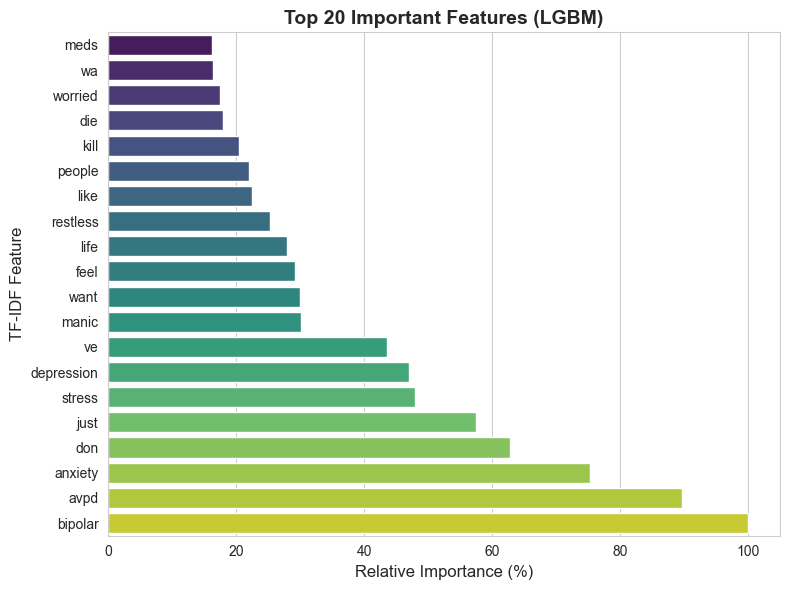

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if LGBM is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = LGBM.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (LGBM)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_lgbm.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


## Cross-Domain Generalization Test - On Complete New Dataset


In [33]:
new_test = pd.read_csv('Sentiment_Mental_health_dataset.csv')

In [34]:
new_test.dropna(inplace = True)

In [35]:
new_test.shape
# new_test = new_test.iloc[:,1:]

(26350, 2)

In [36]:
new_test.head()

,statement,status
0,Anyone else have symptoms much improved after ...,Bipolar
1,"I basicaly do not exist, sure feels that way. ...",Suicidal
2,Finding a sense of self It's like one minute I...,Personality_disorder
3,Putting into words what were just tangles in m...,Anxiety
4,Anxiety makes me worry about my public image s...,Anxiety


In [37]:
new_test.describe().T

,count,unique,top,freq
statement,26350,26329,.,4
status,26350,7,Suicidal,5600


In [38]:
new_test["status"] = new_test["status"].replace({
    "personality_disorder": "Personality disorder",
    "Personality_disorder": "Personality disorder",
    "personality disorder": "Personality disorder"
})

In [39]:
import joblib
label_encoder = joblib.load('Models/le.pkl')
new_test['encoded_status'] = label_encoder.transform(new_test['status'])

In [40]:
new_test.head()

,statement,status,encoded_status
0,Anyone else have symptoms much improved after ...,Bipolar,1
1,"I basicaly do not exist, sure feels that way. ...",Suicidal,6
2,Finding a sense of self It's like one minute I...,Personality disorder,4
3,Putting into words what were just tangles in m...,Anxiety,0
4,Anxiety makes me worry about my public image s...,Anxiety,0


## 1 Classical ML Model

### 1.0 Pre-processing for classical ML Models


In [41]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

new_test['statement'] = new_test['statement'].apply(clean_text)

In [42]:
stop_words = set(stopwords.words('english'))
new_test['statement'] = new_test['statement'].apply(lambda x:' '.join([word for word in x.split() if word not in stop_words]))

In [43]:
lemmatizer = WordNetLemmatizer()
new_test['statement'] = new_test['statement'].apply(lambda x:' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [44]:
x_test = new_test['statement'].tolist()
y_test_new = new_test['encoded_status'].tolist()

In [45]:
_, x_test, _, y_test_new = train_test_split(
    x_test, y_test_new, test_size=0.2, random_state=42
)

In [46]:
# print(new_test.shape, x_test.shape, y_test_new.shape)

In [47]:
vectorizer = joblib.load('Models/tfidf_vectorizer_2.pkl')
x_test_new = vectorizer.transform(x_test)

In [48]:
x_test_new.shape

(5270, 10000)

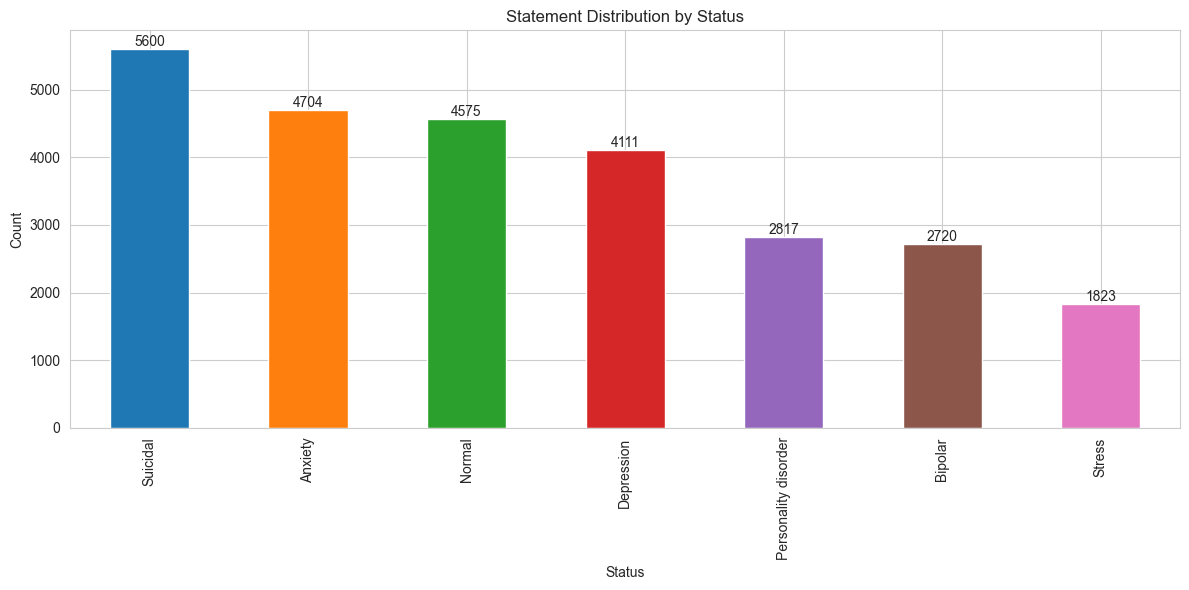

In [49]:
# plt.figure(figsize= (8, 8))
# status_counts = new_test['status'].value_counts()
# ax = status_counts.plot(kind = 'bar')
# for i, v in enumerate(status_counts):
#     ax.text(i, v, str(v), ha='center', va= 'bottom')

# plt.title('Statement Distribution by Status of New Dataset')
# plt.xlabel('Status')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.show()

import matplotlib.cm as cm

plt.figure(figsize=(12,6))
status_counts = new_test['status'].value_counts()

# Use a color map to generate distinct colors
colors = cm.tab10(range(len(status_counts)))  # 'tab10', 'Set3', 'viridis', etc.

ax = status_counts.plot(kind='bar', color=colors)

for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement Distribution by Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [50]:
# Load model and encoder
SVM = joblib.load('Models/svm_model_multi.pkl')
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample
def bootstrap_auc_ci_multiclass(y_true, y_scores, n_classes, n_iterations=1000, average="macro"):
    auc_scores = []
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        y_true_sample = y_true_bin[indices]
        y_scores_sample = y_scores[indices]
        try:
            auc_sample = roc_auc_score(y_true_sample, y_scores_sample, average=average, multi_class="ovr")
            auc_scores.append(auc_sample)
        except ValueError:
            continue

    return np.mean(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)


def plot_multiclass_roc(y_true, y_score, n_classes, label_prefix="Model"):
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(["blue", "green", "red", "cyan", "magenta", "orange", "darkblue"])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label_prefix} - Multi-class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper

def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_multiclass(model, X_test, y_test, model_name="Model"):
    print(f"\n--- Evaluation Report: {model_name} ---\n")
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # F1 Score with CI
    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    # Confusion Matrix
    labels = list(np.unique(y_test))
    plot_confusion_matrix(y_test, y_pred, labels=labels)

    # ROC & AUC (One-vs-Rest)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print("Model doesn't support probability or decision scores.")
        return

    n_classes = len(np.unique(y_test))
    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci_multiclass(y_test, y_scores, n_classes)
    print(f"Macro-Averaged AUC: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_multiclass_roc(y_test, y_scores, n_classes, label_prefix=model_name)




## 1. SVM 


--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7955    0.2778    0.4118       882
           1     0.9205    0.5167    0.6619       538
           2     0.2239    0.8413    0.3536       832
           3     0.5326    0.5704    0.5509       959
           4     1.0000    0.0157    0.0308       575
           5     0.8235    0.2932    0.4324       382
           6     0.7313    0.2396    0.3609      1102

    accuracy                         0.4089      5270
   macro avg     0.7182    0.3935    0.4003      5270
weighted avg     0.6811    0.4089    0.4027      5270

Weighted F1 Score: 0.4024
95% CI for F1 Score: [0.3884, 0.4170]


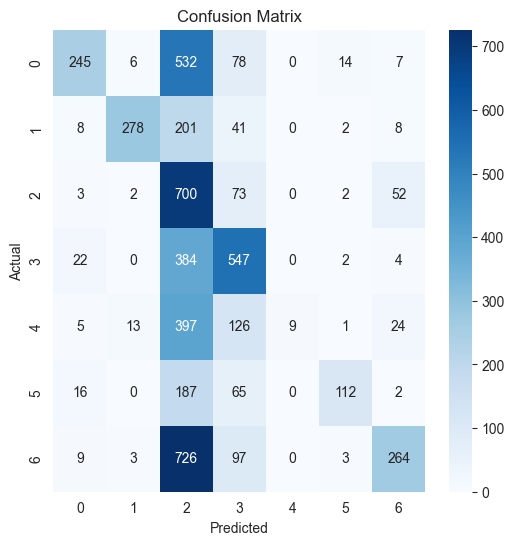

Macro-Averaged AUC: 0.8360
95% CI for AUC: [0.8286, 0.8431]


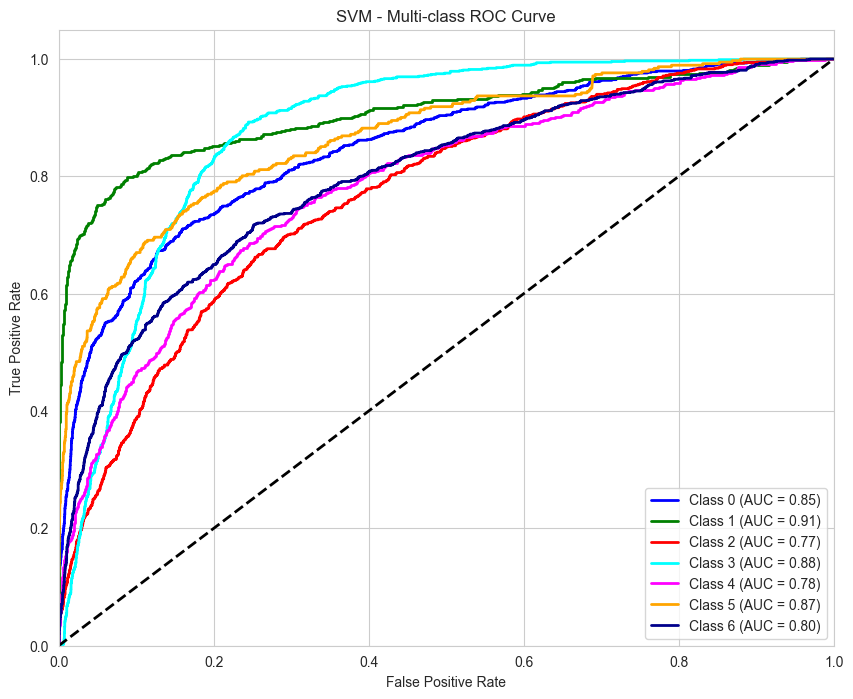

In [51]:
evaluate_model_multiclass(SVM, x_test_new, y_test_new, model_name="SVM")

## 2. LR


--- Evaluation Report: Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7794    0.3005    0.4337       882
           1     0.7955    0.5279    0.6346       538
           2     0.2227    0.8017    0.3486       832
           3     0.5134    0.4400    0.4739       959
           4     0.5745    0.0470    0.0868       575
           5     0.5322    0.3246    0.4033       382
           6     0.6092    0.2632    0.3676      1102

    accuracy                         0.3945      5270
   macro avg     0.5753    0.3864    0.3926      5270
weighted avg     0.5689    0.3945    0.3942      5270

Weighted F1 Score: 0.3941
95% CI for F1 Score: [0.3798, 0.4073]


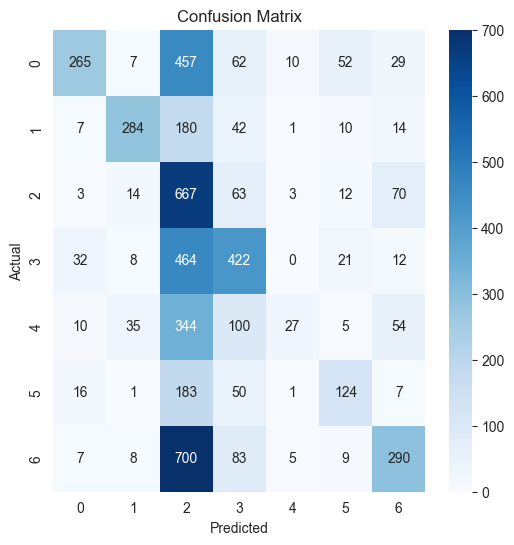

Macro-Averaged AUC: 0.8061
95% CI for AUC: [0.7983, 0.8142]


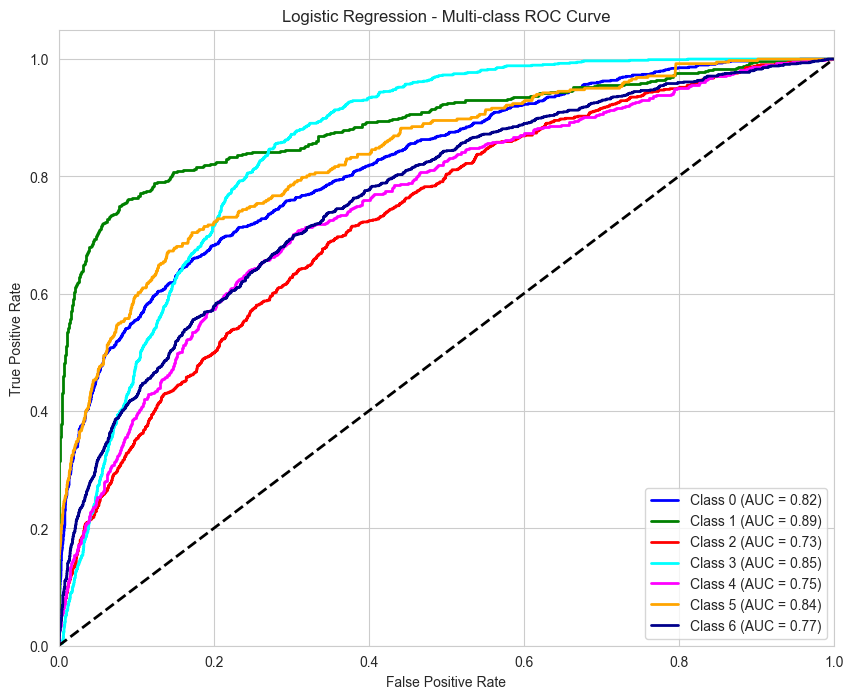

In [52]:
evaluate_model_multiclass(LR, x_test_new, y_test_new, model_name="Logistic Regression")


## 3. Random Forest


--- Evaluation Report: RandomForest ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7443    0.4853    0.5875       882
           1     0.7796    0.6115    0.6854       538
           2     0.2590    0.7091    0.3794       832
           3     0.5539    0.4661    0.5062       959
           4     0.9714    0.0591    0.1115       575
           5     0.7080    0.4634    0.5601       382
           6     0.6257    0.5127    0.5636      1102

    accuracy                         0.4877      5270
   macro avg     0.6631    0.4725    0.4848      5270
weighted avg     0.6340    0.4877    0.4909      5270

Weighted F1 Score: 0.4911
95% CI for F1 Score: [0.4775, 0.5048]


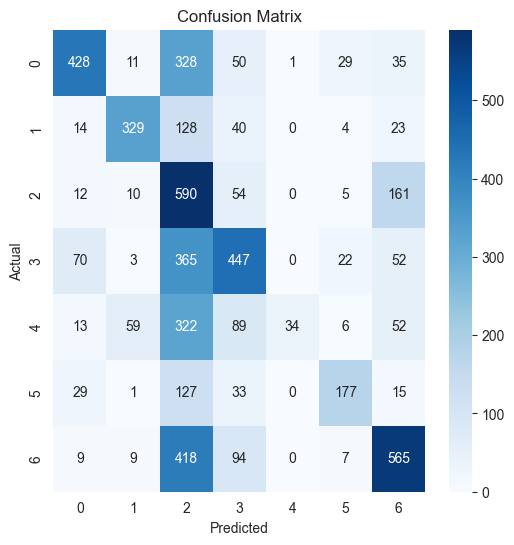

Macro-Averaged AUC: 0.8466
95% CI for AUC: [0.8389, 0.8539]


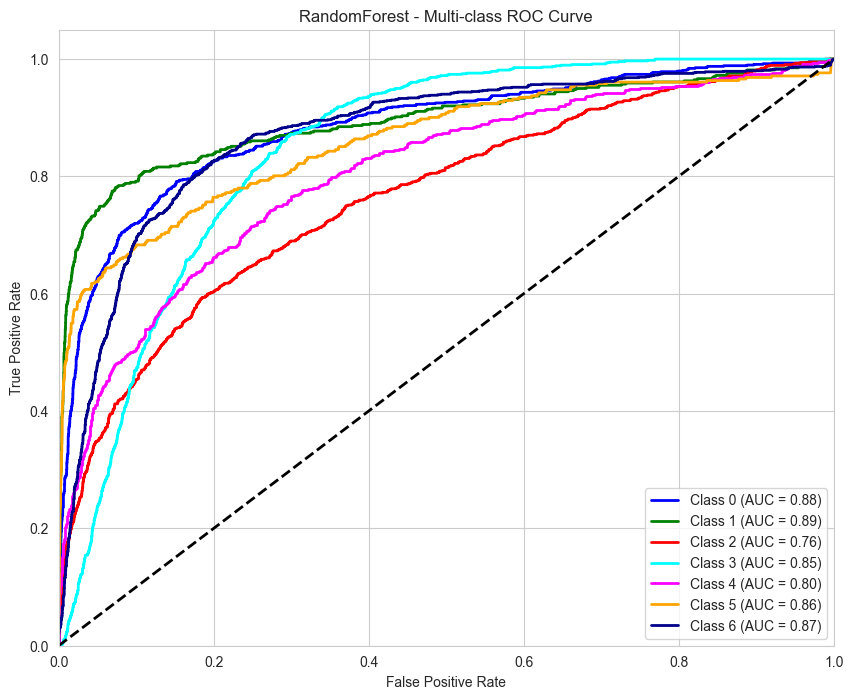

In [53]:
evaluate_model_multiclass(RandomForest, x_test_new, y_test_new, model_name="RandomForest")


## 4. LGBM


--- Evaluation Report: LightGBM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7286    0.4048    0.5204       882
           1     0.7840    0.6543    0.7133       538
           2     0.2448    0.8185    0.3769       832
           3     0.5773    0.4244    0.4892       959
           4     0.7692    0.0348    0.0666       575
           5     0.5640    0.5079    0.5344       382
           6     0.5802    0.2495    0.3490      1102

    accuracy                         0.4338      5270
   macro avg     0.6069    0.4420    0.4357      5270
weighted avg     0.5918    0.4338    0.4274      5270

Weighted F1 Score: 0.4273
95% CI for F1 Score: [0.4146, 0.4409]


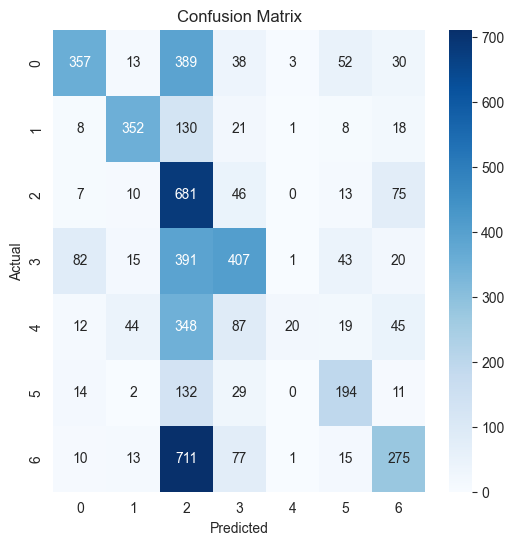

Macro-Averaged AUC: 0.8234
95% CI for AUC: [0.8163, 0.8307]


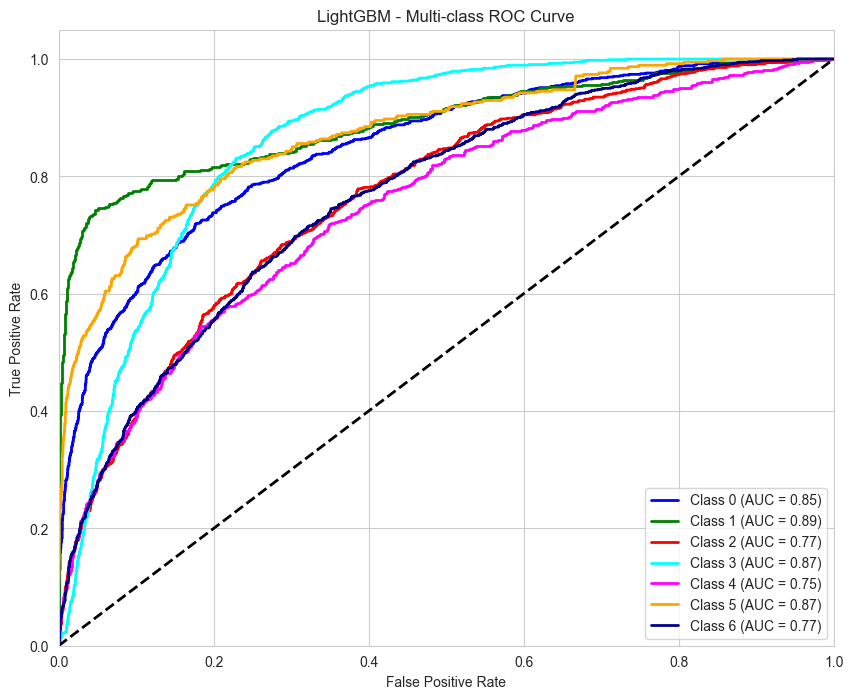

In [54]:
evaluate_model_multiclass(LGBM, x_test_new, y_test_new, model_name="LightGBM")


## Cross-Domain Generalization Test - On Merge New Dataset


In [55]:
new_test = pd.read_csv('Final_Merged_Dataset_Cleaned.csv')

In [56]:
new_test.dropna(inplace = True)

In [57]:
new_test.shape
# new_test = new_test.iloc[:,1:]

(41835, 2)

In [58]:
new_test.head()

,statement,status
0,That’s it that’s the post lmao,Suicidal
1,Before exam I am so stressed out that I am not...,Stress
2,I’m afraid of having my pictures taken Ever si...,Anxiety
3,Let's say a totally optimally fit person were ...,Normal
4,"And no, this is not teenage angst. This is not...",Suicidal


In [59]:
new_test.describe().T

,count,unique,top,freq
statement,41835,41077,what do you mean?,7
status,41835,7,Normal,8573


In [60]:
new_test["status"] = new_test["status"].replace({
    "personality_disorder": "Personality disorder",
    "Personality_disorder": "Personality disorder",
    "personality disorder": "Personality disorder"
})

In [61]:
import joblib
label_encoder = joblib.load('Models/le.pkl')
new_test['encoded_status'] = label_encoder.transform(new_test['status'])

In [62]:
new_test.head()

,statement,status,encoded_status
0,That’s it that’s the post lmao,Suicidal,6
1,Before exam I am so stressed out that I am not...,Stress,5
2,I’m afraid of having my pictures taken Ever si...,Anxiety,0
3,Let's say a totally optimally fit person were ...,Normal,3
4,"And no, this is not teenage angst. This is not...",Suicidal,6


## 1 Classical ML Model

### 1.0 Pre-processing for classical ML Models


In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

new_test['statement'] = new_test['statement'].apply(clean_text)

In [64]:
stop_words = set(stopwords.words('english'))
new_test['statement'] = new_test['statement'].apply(lambda x:' '.join([word for word in x.split() if word not in stop_words]))

In [65]:
lemmatizer = WordNetLemmatizer()
new_test['statement'] = new_test['statement'].apply(lambda x:' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [66]:
x_test = new_test['statement'].tolist()
y_test_new = new_test['encoded_status'].tolist()

In [67]:
_, x_test, _, y_test_new = train_test_split(
    x_test, y_test_new, test_size=0.2, random_state=42
)

In [68]:
vectorizer = joblib.load('Models/tfidf_vectorizer_2.pkl')
x_test_new = vectorizer.transform(x_test)

In [69]:
x_test_new.shape

(8367, 10000)

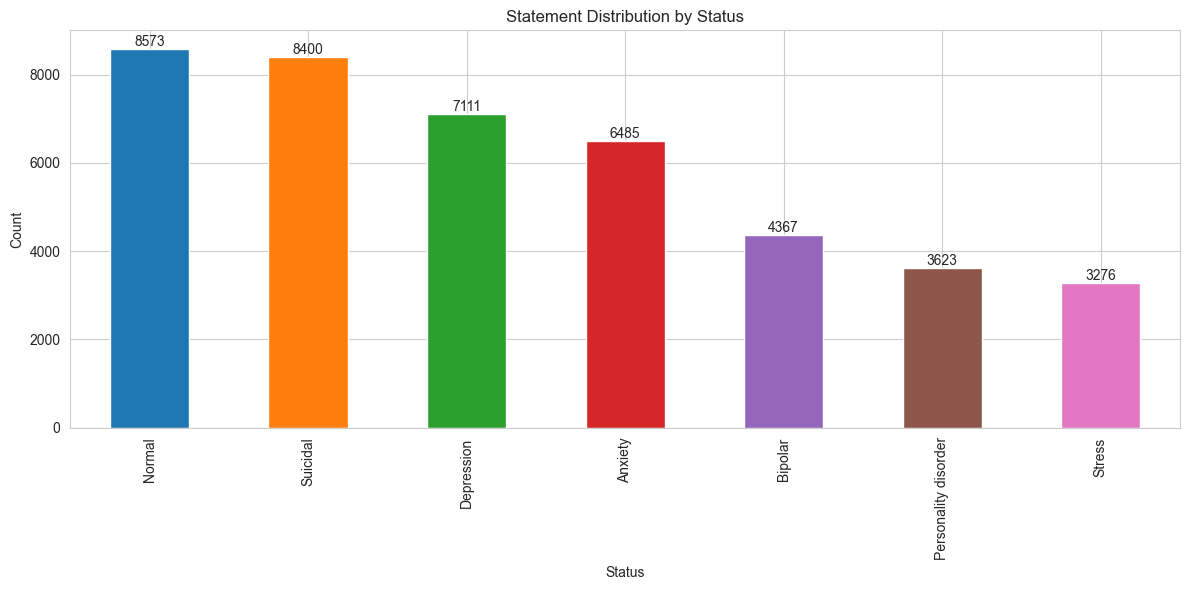

In [70]:
# plt.figure(figsize= (8, 8))
# status_counts = new_test['status'].value_counts()
# ax = status_counts.plot(kind = 'bar')
# for i, v in enumerate(status_counts):
#     ax.text(i, v, str(v), ha='center', va= 'bottom')

# plt.title('Statement Distribution by Status of New Dataset')
# plt.xlabel('Status')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.show()

import matplotlib.cm as cm

plt.figure(figsize=(12,6))
status_counts =new_test['status'].value_counts()

# Use a color map to generate distinct colors
colors = cm.tab10(range(len(status_counts)))  # 'tab10', 'Set3', 'viridis', etc.

ax = status_counts.plot(kind='bar', color=colors)

for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement Distribution by Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [71]:
# Load model and encoder
SVM = joblib.load('Models/svm_model_multi.pkl')
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample
def bootstrap_auc_ci_multiclass(y_true, y_scores, n_classes, n_iterations=1000, average="macro"):
    auc_scores = []
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        y_true_sample = y_true_bin[indices]
        y_scores_sample = y_scores[indices]
        try:
            auc_sample = roc_auc_score(y_true_sample, y_scores_sample, average=average, multi_class="ovr")
            auc_scores.append(auc_sample)
        except ValueError:
            continue

    return np.mean(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)


def plot_multiclass_roc(y_true, y_score, n_classes, label_prefix="Model"):
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(["blue", "green", "red", "cyan", "magenta", "orange", "darkblue"])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label_prefix} - Multi-class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper

def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_multiclass(model, X_test, y_test, model_name="Model"):
    print(f"\n--- Evaluation Report: {model_name} ---\n")
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # F1 Score with CI
    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    # Confusion Matrix
    labels = list(np.unique(y_test))
    plot_confusion_matrix(y_test, y_pred, labels=labels)

    # ROC & AUC (One-vs-Rest)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print("Model doesn't support probability or decision scores.")
        return

    n_classes = len(np.unique(y_test))
    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci_multiclass(y_test, y_scores, n_classes)
    print(f"Macro-Averaged AUC: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_multiclass_roc(y_test, y_scores, n_classes, label_prefix=model_name)




## 1. SVM 


--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8850    0.4384    0.5864      1316
           1     0.9494    0.5916    0.7290       857
           2     0.3102    0.8717    0.4575      1418
           3     0.6831    0.7675    0.7228      1755
           4     1.0000    0.1479    0.2578       730
           5     0.8885    0.4100    0.5611       661
           6     0.8002    0.3982    0.5317      1630

    accuracy                         0.5611      8367
   macro avg     0.7881    0.5179    0.5495      8367
weighted avg     0.7456    0.5611    0.5665      8367

Weighted F1 Score: 0.5664
95% CI for F1 Score: [0.5561, 0.5771]


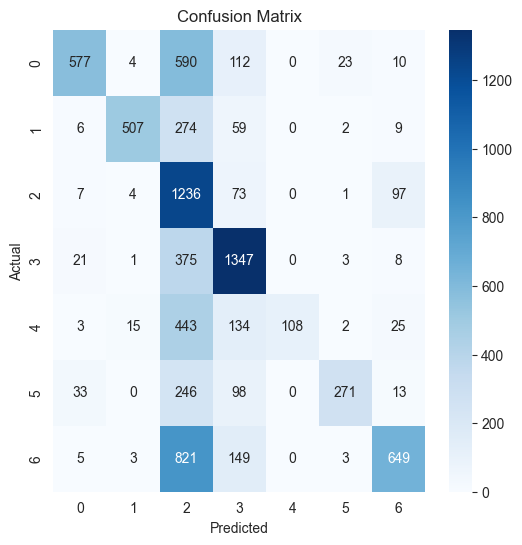

Macro-Averaged AUC: 0.9001
95% CI for AUC: [0.8952, 0.9049]


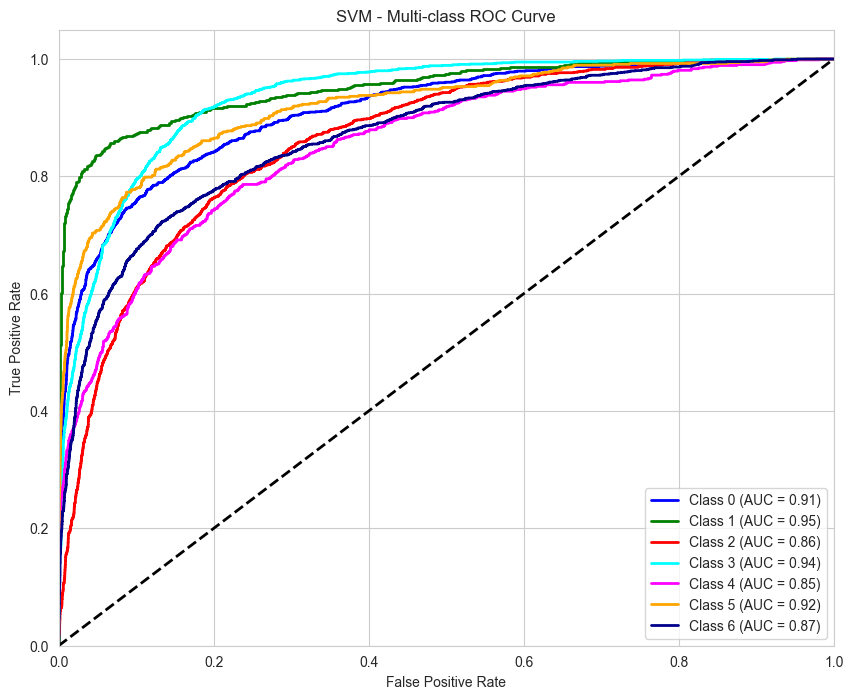

In [72]:
evaluate_model_multiclass(SVM, x_test_new, y_test_new, model_name="SVM")

## 2. LR


--- Evaluation Report: Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8528    0.4096    0.5534      1316
           1     0.8638    0.5624    0.6813       857
           2     0.2971    0.8441    0.4395      1418
           3     0.6806    0.6860    0.6833      1755
           4     0.8413    0.1452    0.2477       730
           5     0.6781    0.3601    0.4704       661
           6     0.6729    0.3724    0.4795      1630

    accuracy                         0.5226      8367
   macro avg     0.6981    0.4828    0.5079      8367
weighted avg     0.6738    0.5226    0.5268      8367

Weighted F1 Score: 0.5268
95% CI for F1 Score: [0.5158, 0.5380]


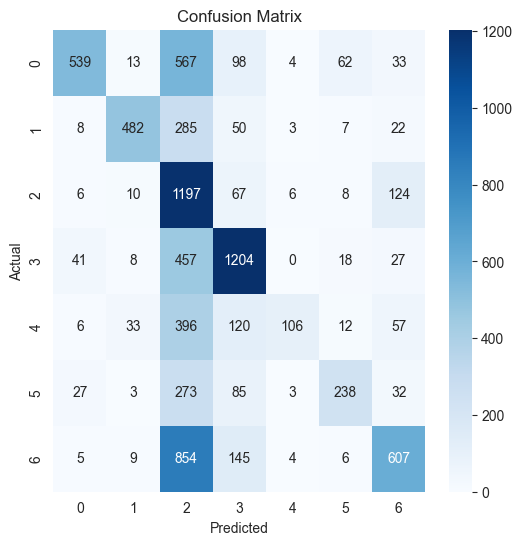

Macro-Averaged AUC: 0.8666
95% CI for AUC: [0.8613, 0.8719]


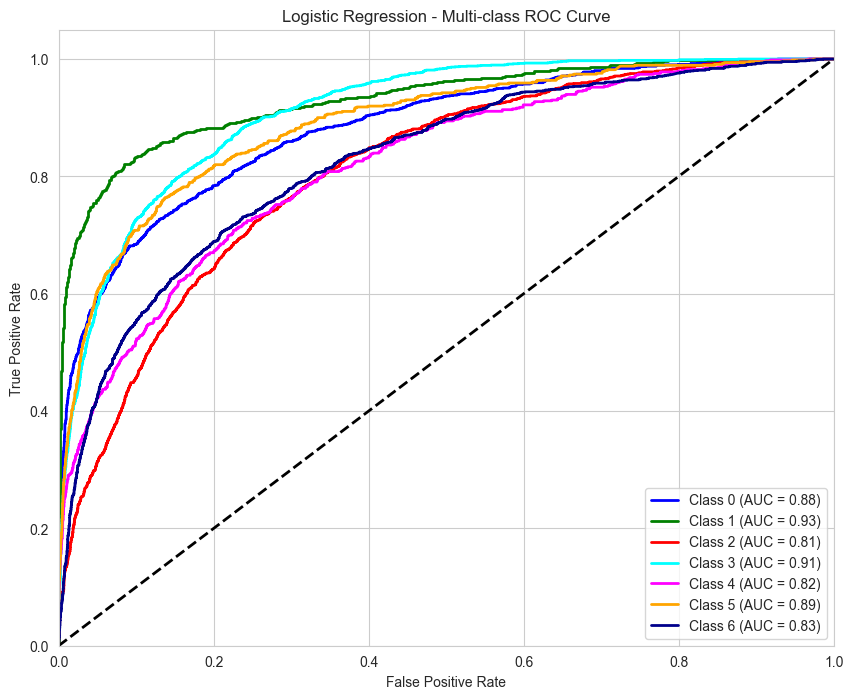

In [73]:
evaluate_model_multiclass(LR, x_test_new, y_test_new, model_name="Logistic Regression")


## 3. Random Forest


--- Evaluation Report: RandomForest ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7962    0.5669    0.6622      1316
           1     0.8558    0.6371    0.7304       857
           2     0.3273    0.6883    0.4436      1418
           3     0.6821    0.6883    0.6852      1755
           4     0.9831    0.1589    0.2736       730
           5     0.7659    0.5098    0.6122       661
           6     0.6388    0.5804    0.6082      1630

    accuracy                         0.5826      8367
   macro avg     0.7213    0.5471    0.5736      8367
weighted avg     0.6821    0.5826    0.5886      8367

Weighted F1 Score: 0.5884
95% CI for F1 Score: [0.5776, 0.5990]


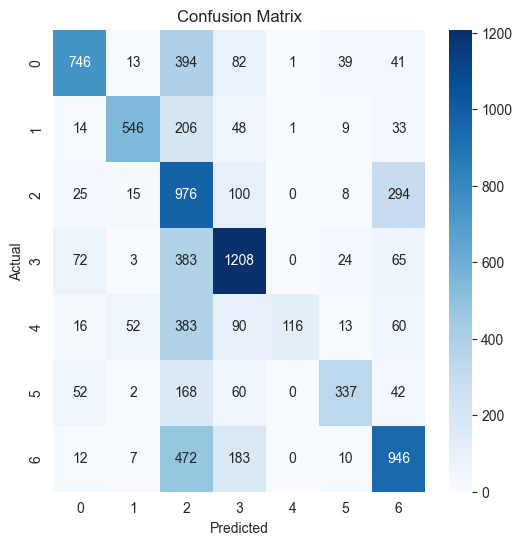

Macro-Averaged AUC: 0.8877
95% CI for AUC: [0.8830, 0.8922]


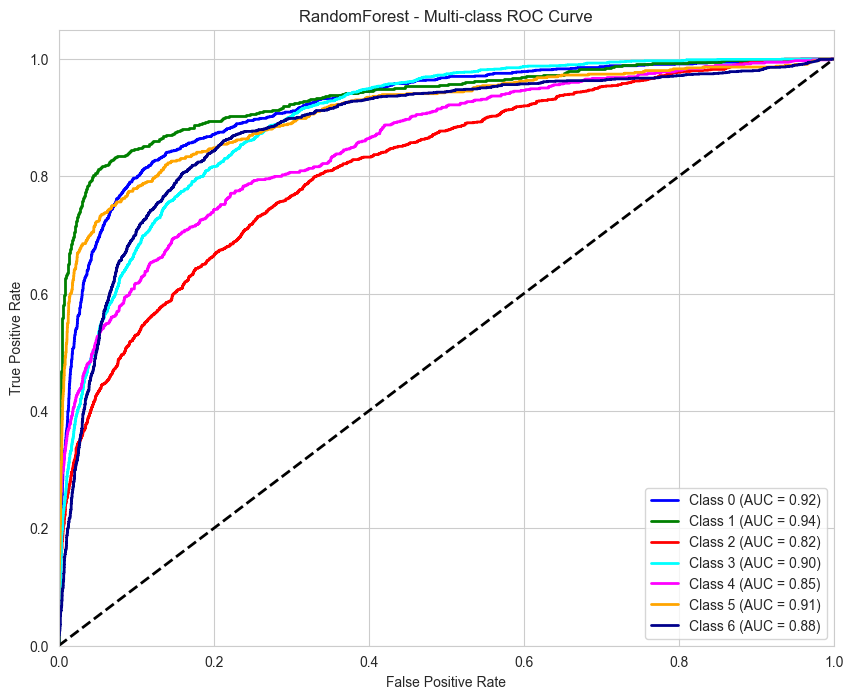

In [74]:
evaluate_model_multiclass(RandomForest, x_test_new, y_test_new, model_name="RandomForest")


## 4. LGBM


--- Evaluation Report: LightGBM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8062    0.5152    0.6287      1316
           1     0.8624    0.6803    0.7606       857
           2     0.3205    0.8138    0.4599      1418
           3     0.7307    0.6587    0.6928      1755
           4     0.9291    0.1616    0.2754       730
           5     0.6942    0.5598    0.6198       661
           6     0.6733    0.4160    0.5142      1630

    accuracy                         0.5662      8367
   macro avg     0.7166    0.5436    0.5645      8367
weighted avg     0.6898    0.5662    0.5732      8367

Weighted F1 Score: 0.5734
95% CI for F1 Score: [0.5636, 0.5844]


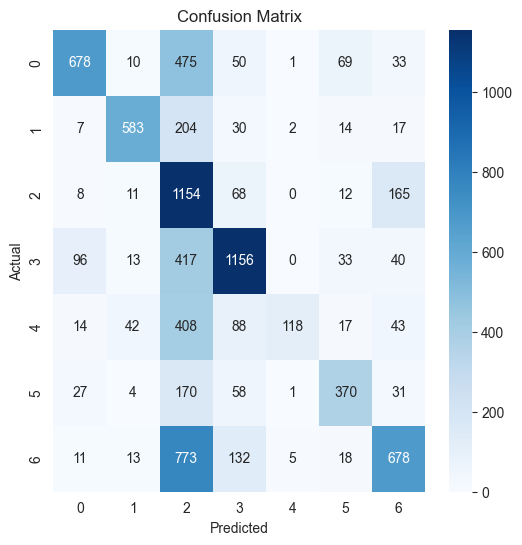

Macro-Averaged AUC: 0.8796
95% CI for AUC: [0.8746, 0.8846]


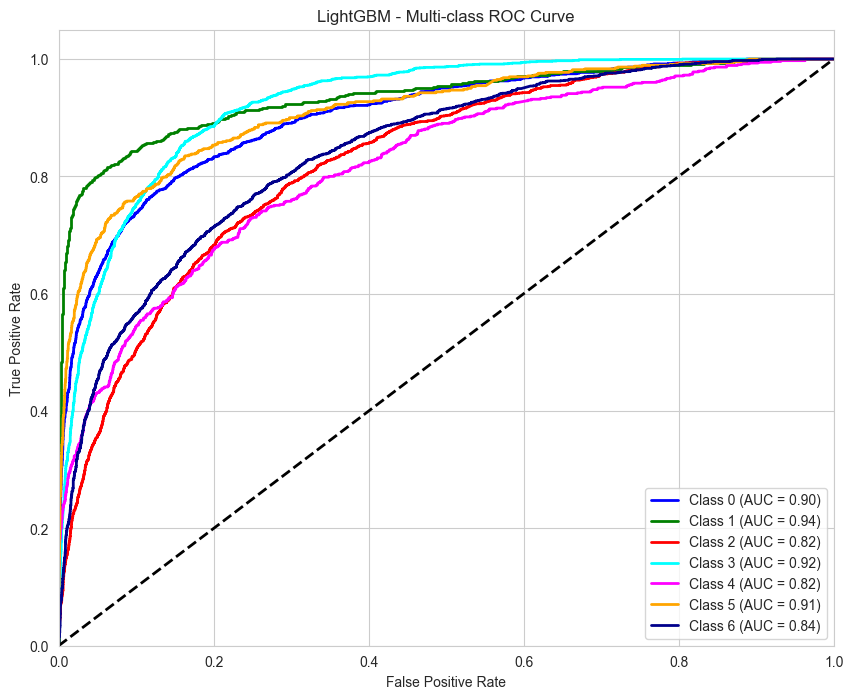

In [75]:
evaluate_model_multiclass(LGBM, x_test_new, y_test_new, model_name="LightGBM")


In [76]:
new_test['encoded_status'].unique()

array([6, 5, 0, 3, 2, 1, 4])

In [77]:
new_test['encoded_status'].value_counts()

encoded_status
3    8573
6    8400
2    7111
0    6485
1    4367
4    3623
5    3276
Name: count, dtype: int64

In [78]:
new_test['status'].value_counts()

status
Normal                  8573
Suicidal                8400
Depression              7111
Anxiety                 6485
Bipolar                 4367
Personality disorder    3623
Stress                  3276
Name: count, dtype: int64

In [79]:
df1['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64